In [1]:
import pandas as pd
import pypelines.clustering as pipe
import os
folder = 'C:/Users/Kreshnaa Raam/Documents/Projects/pypelines/pypelines'
os.chdir(f'{folder}')

In [2]:
kmeans_data = pd.read_csv("./datasets/clustering/kmeans.csv")

In [3]:
km_pypelines_all = pipe.ClusteringPipeline(data = kmeans_data
                                           ,predictions_data=kmeans_data
                                           #,models = ['KMeans']
                                           ,nfolds = 1)

In [4]:
km_pypelines_all.code_to_clipboard()

['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
['Genre']
[]
Fitting 1 folds for each of 14 candidates, totalling 14 fits
[CV 1/1] END ........max_iter=100, n_clusters=3;, score=0.419 total time=   0.1s


c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python31

[CV 1/1] END ........max_iter=100, n_clusters=4;, score=0.317 total time=   0.0s
[CV 1/1] END ........max_iter=100, n_clusters=5;, score=0.336 total time=   0.0s
[CV 1/1] END ........max_iter=100, n_clusters=6;, score=0.340 total time=   0.0s
[CV 1/1] END ........max_iter=100, n_clusters=7;, score=0.386 total time=   0.0s
[CV 1/1] END ........max_iter=100, n_clusters=8;, score=0.418 total time=   0.0s
[CV 1/1] END ........max_iter=100, n_clusters=9;, score=0.419 total time=   0.0s


c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python31

[CV 1/1] END ........max_iter=150, n_clusters=3;, score=0.419 total time=   0.0s
[CV 1/1] END ........max_iter=150, n_clusters=4;, score=0.317 total time=   0.0s
[CV 1/1] END ........max_iter=150, n_clusters=5;, score=0.337 total time=   0.0s
[CV 1/1] END ........max_iter=150, n_clusters=6;, score=0.381 total time=   0.0s
[CV 1/1] END ........max_iter=150, n_clusters=7;, score=0.383 total time=   0.0s
[CV 1/1] END ........max_iter=150, n_clusters=8;, score=0.418 total time=   0.0s
[CV 1/1] END ........max_iter=150, n_clusters=9;, score=0.425 total time=   0.0s
For n_clusters = 9 The average silhouette_score is : 0.4211199799880569


c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


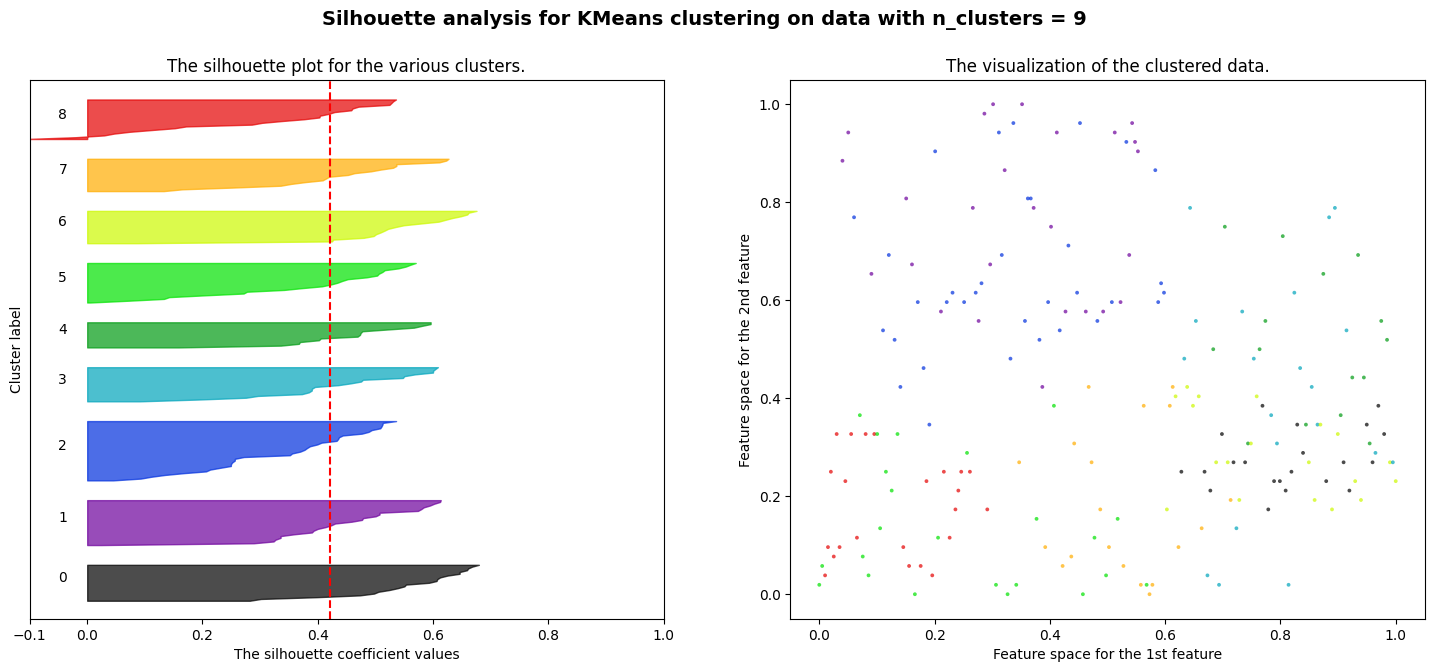

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV 1/1] END .convergence_iter=15, max_iter=100;, score=0.441 total time=   0.0s
[CV 1/1] END .convergence_iter=15, max_iter=150;, score=0.441 total time=   0.0s
[CV 1/1] END .convergence_iter=35, max_iter=100;, score=0.441 total time=   0.0s
[CV 1/1] END .convergence_iter=35, max_iter=150;, score=0.441 total time=   0.0s
For n_clusters = 10 The average silhouette_score is : 0.44143589598070987


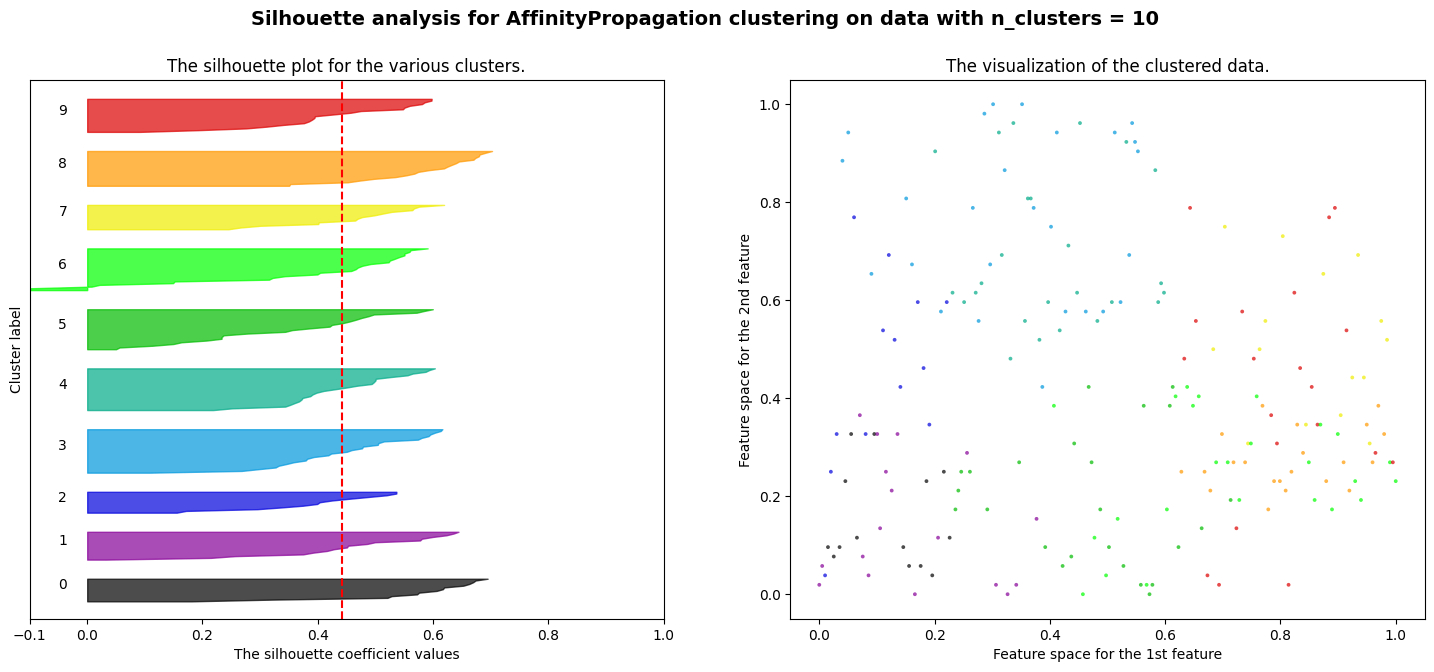

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1] END ......................max_iter=100;, score=0.574 total time=   0.6s
[CV 1/1] END ......................max_iter=150;, score=0.574 total time=   0.6s
[CV 1/1] END ......................max_iter=200;, score=0.574 total time=   0.5s
[CV 1/1] END ......................max_iter=250;, score=0.574 total time=   0.5s
[CV 1/1] END ......................max_iter=300;, score=0.574 total time=   0.6s
[CV 1/1] END ......................max_iter=350;, score=0.574 total time=   0.6s
For n_clusters = 2 The average silhouette_score is : 0.5739875980283735


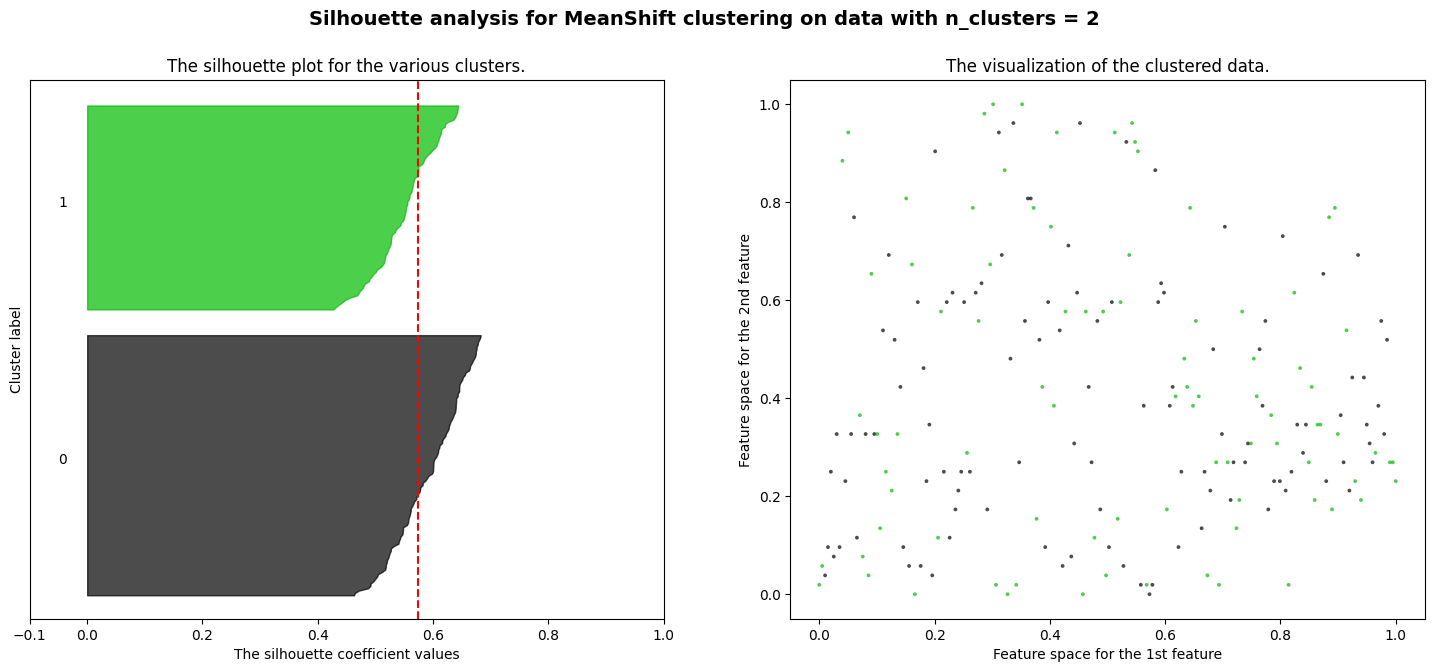

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV 1/1] END ......................n_clusters=3;, score=0.419 total time=   0.2s
[CV 1/1] END ......................n_clusters=4;, score=0.308 total time=   0.2s
[CV 1/1] END ......................n_clusters=5;, score=0.335 total time=   0.2s
[CV 1/1] END ......................n_clusters=6;, score=0.323 total time=   0.3s
[CV 1/1] END ......................n_clusters=7;, score=0.381 total time=   0.2s
[CV 1/1] END ......................n_clusters=8;, score=0.416 total time=   0.2s
[CV 1/1] END ......................n_clusters=9;, score=0.419 total time=   0.2s
For n_clusters = 3 The average silhouette_score is : 0.4189736698802401


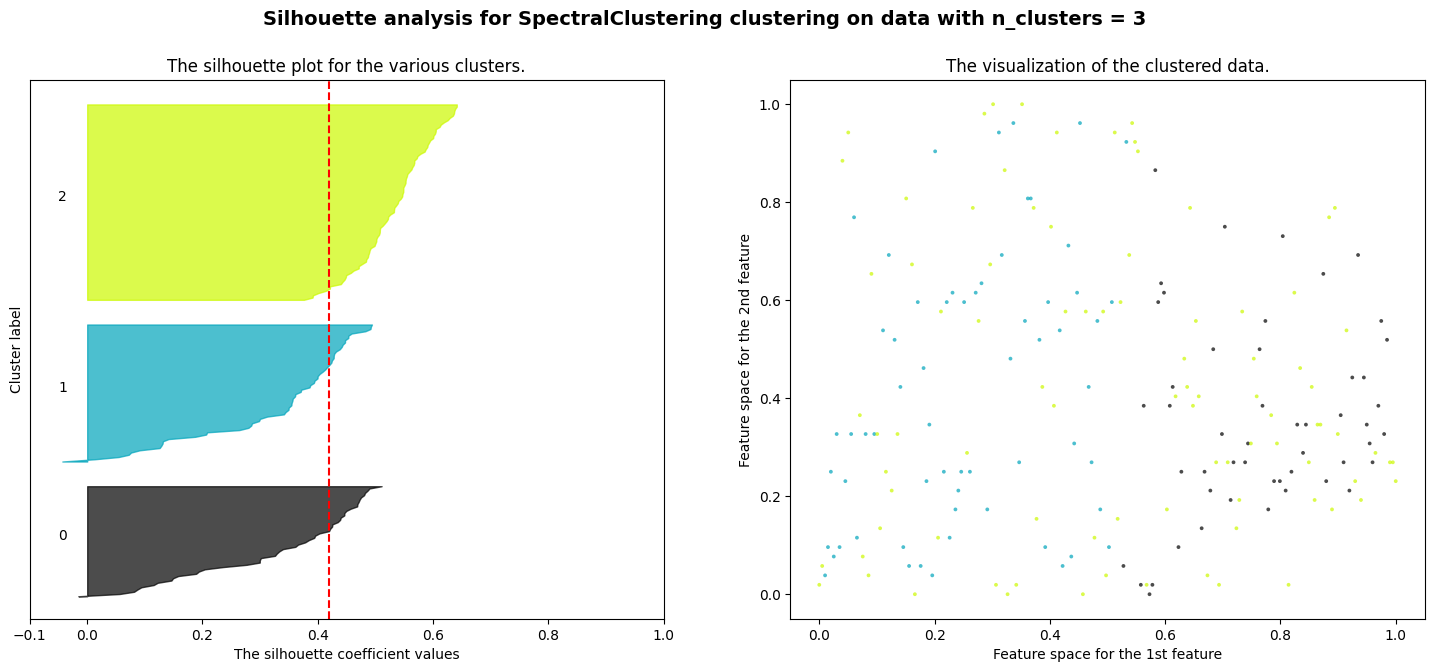

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV 1/1] END ......................n_clusters=3;, score=0.419 total time=   0.0s
[CV 1/1] END ......................n_clusters=4;, score=0.311 total time=   0.0s
[CV 1/1] END ......................n_clusters=5;, score=0.334 total time=   0.0s
[CV 1/1] END ......................n_clusters=6;, score=0.379 total time=   0.0s
[CV 1/1] END ......................n_clusters=7;, score=0.372 total time=   0.0s
[CV 1/1] END ......................n_clusters=8;, score=0.411 total time=   0.0s
[CV 1/1] END ......................n_clusters=9;, score=0.430 total time=   0.0s
For n_clusters = 9 The average silhouette_score is : 0.43014454890111664


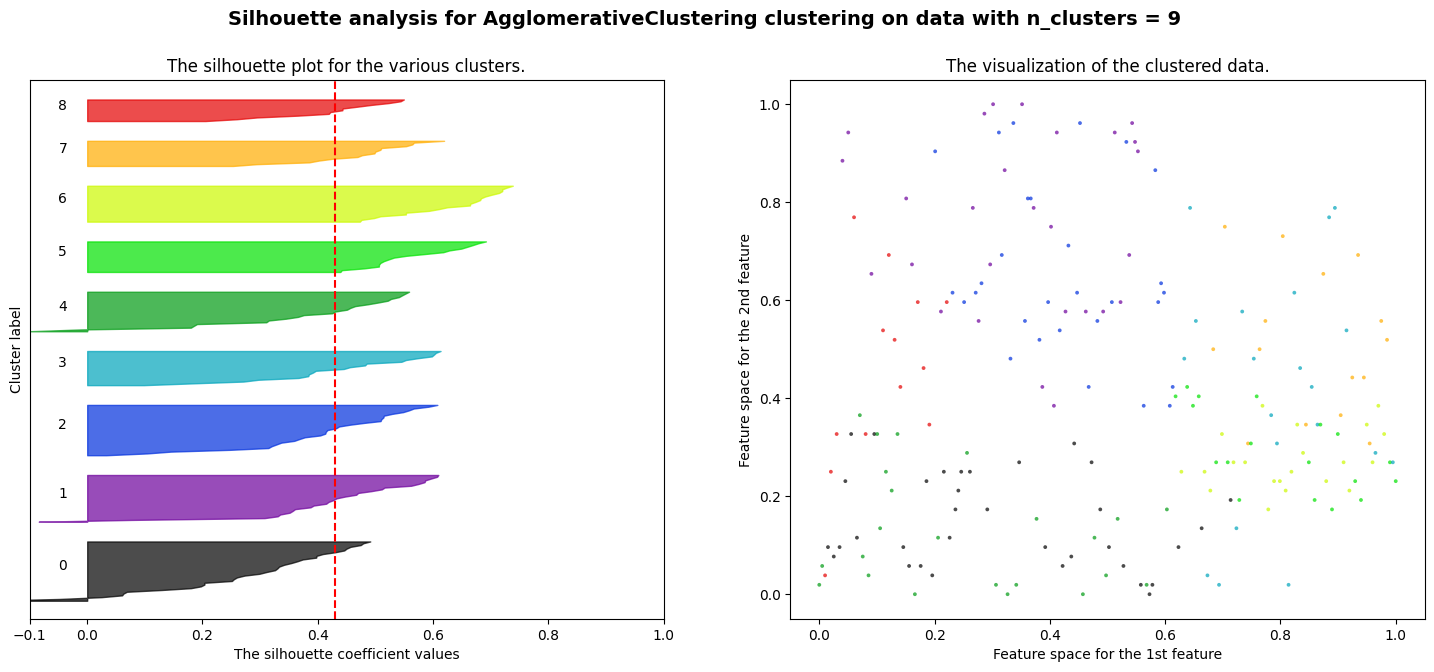

Fitting 1 folds for each of 24 candidates, totalling 24 fits
[CV 1/1] END ...........eps=0.1, min_samples=5;, score=-0.177 total time=   0.0s
[CV 1/1] END ..........eps=0.1, min_samples=10;, score=-1.000 total time=   0.0s
[CV 1/1] END ..........eps=0.1, min_samples=15;, score=-1.000 total time=   0.0s
[CV 1/1] END eps=0.15000000000000002, min_samples=5;, score=-0.080 total time=   0.0s
[CV 1/1] END eps=0.15000000000000002, min_samples=10;, score=-0.037 total time=   0.0s
[CV 1/1] END eps=0.15000000000000002, min_samples=15;, score=-1.000 total time=   0.0s
[CV 1/1] END eps=0.20000000000000004, min_samples=5;, score=0.144 total time=   0.0s
[CV 1/1] END eps=0.20000000000000004, min_samples=10;, score=0.143 total time=   0.0s
[CV 1/1] END eps=0.20000000000000004, min_samples=15;, score=0.024 total time=   0.0s
[CV 1/1] END eps=0.25000000000000006, min_samples=5;, score=0.415 total time=   0.0s
[CV 1/1] END eps=0.25000000000000006, min_samples=10;, score=0.235 total time=   0.0s
[CV 1/1]

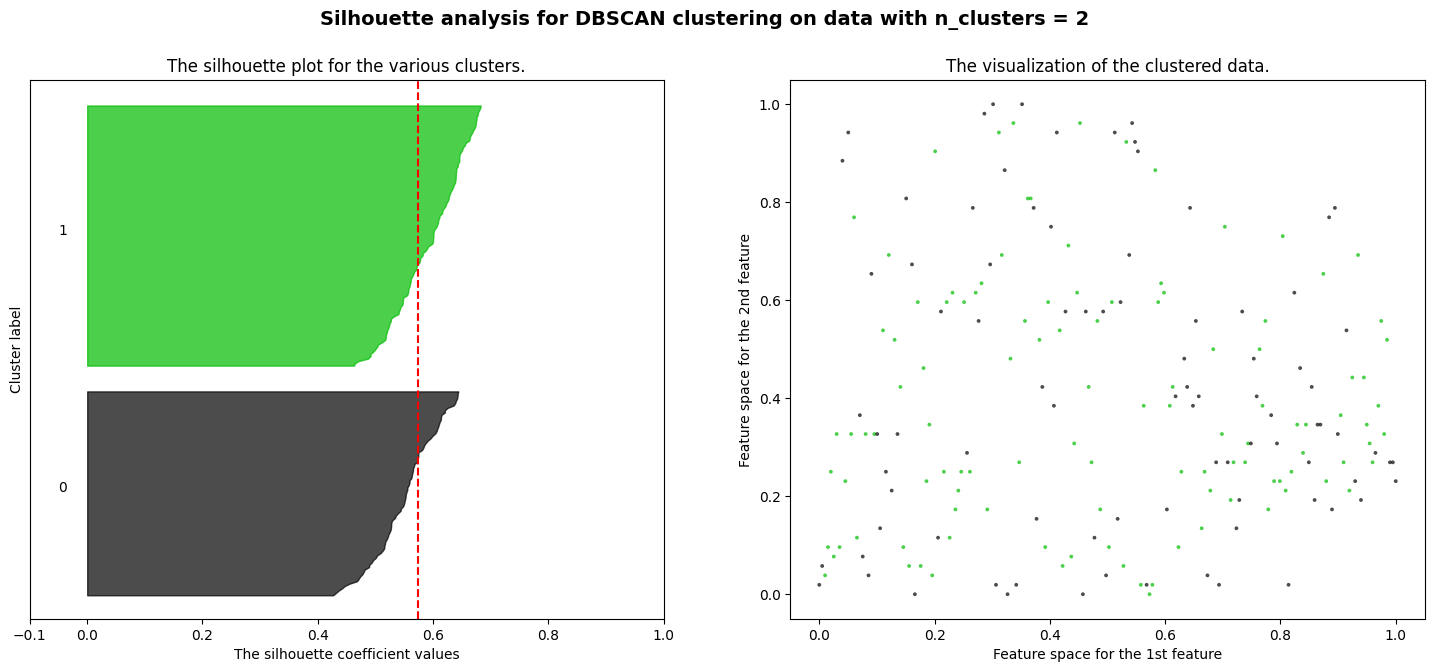

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ................min_cluster_size=5;, score=0.574 total time=   0.0s
[CV 1/1] END ...............min_cluster_size=10;, score=0.574 total time=   0.0s
[CV 1/1] END ...............min_cluster_size=15;, score=0.574 total time=   0.0s
For n_clusters = 2 The average silhouette_score is : 0.5739875980283735


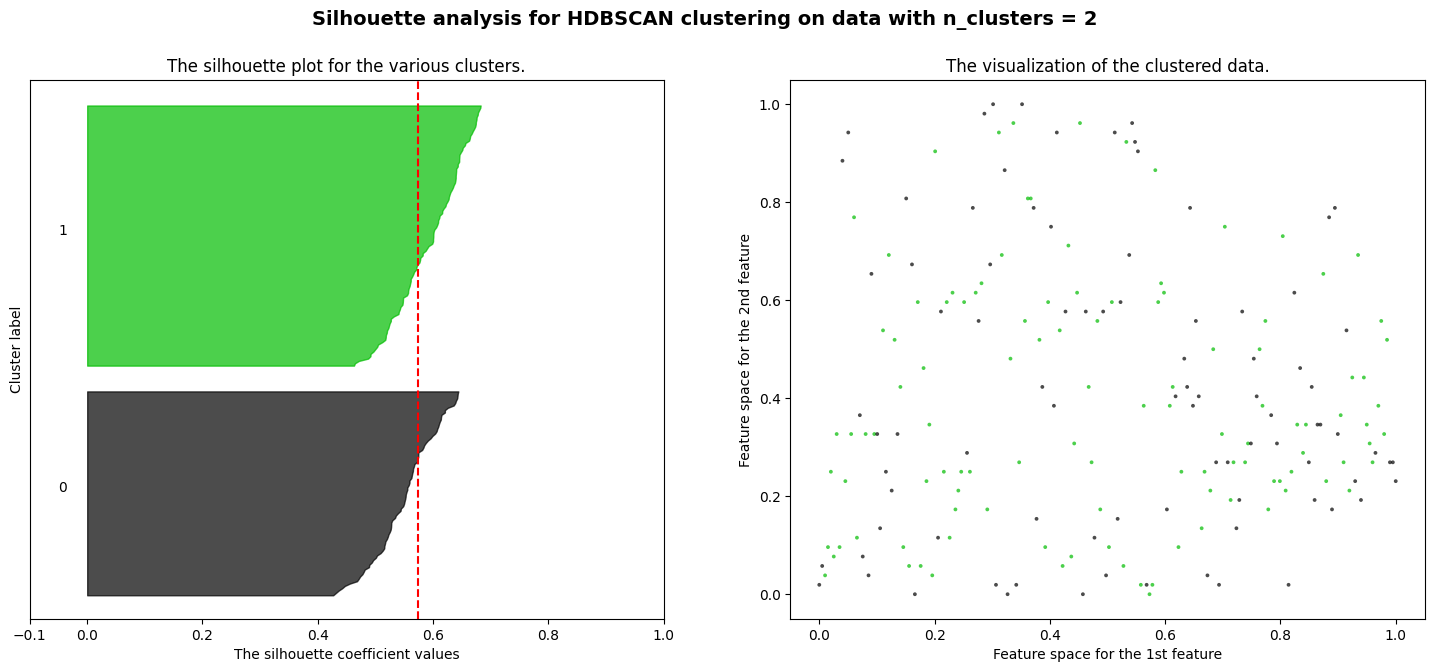

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV 1/1] END ...................min_samples=0.1;, score=0.360 total time=   0.2s
[CV 1/1] END ...................min_samples=0.2;, score=0.574 total time=   0.1s
[CV 1/1] END ...min_samples=0.30000000000000004;, score=0.574 total time=   0.1s
[CV 1/1] END ...................min_samples=0.4;, score=0.574 total time=   0.1s
[CV 1/1] END ..................min_samples=0.5;, score=-1.000 total time=   0.4s
[CV 1/1] END ..................min_samples=0.6;, score=-1.000 total time=   0.4s
[CV 1/1] END ...min_samples=0.7000000000000001;, score=-1.000 total time=   0.4s
[CV 1/1] END ..................min_samples=0.8;, score=-1.000 total time=   0.4s
For n_clusters = 2 The average silhouette_score is : 0.5739875980283735


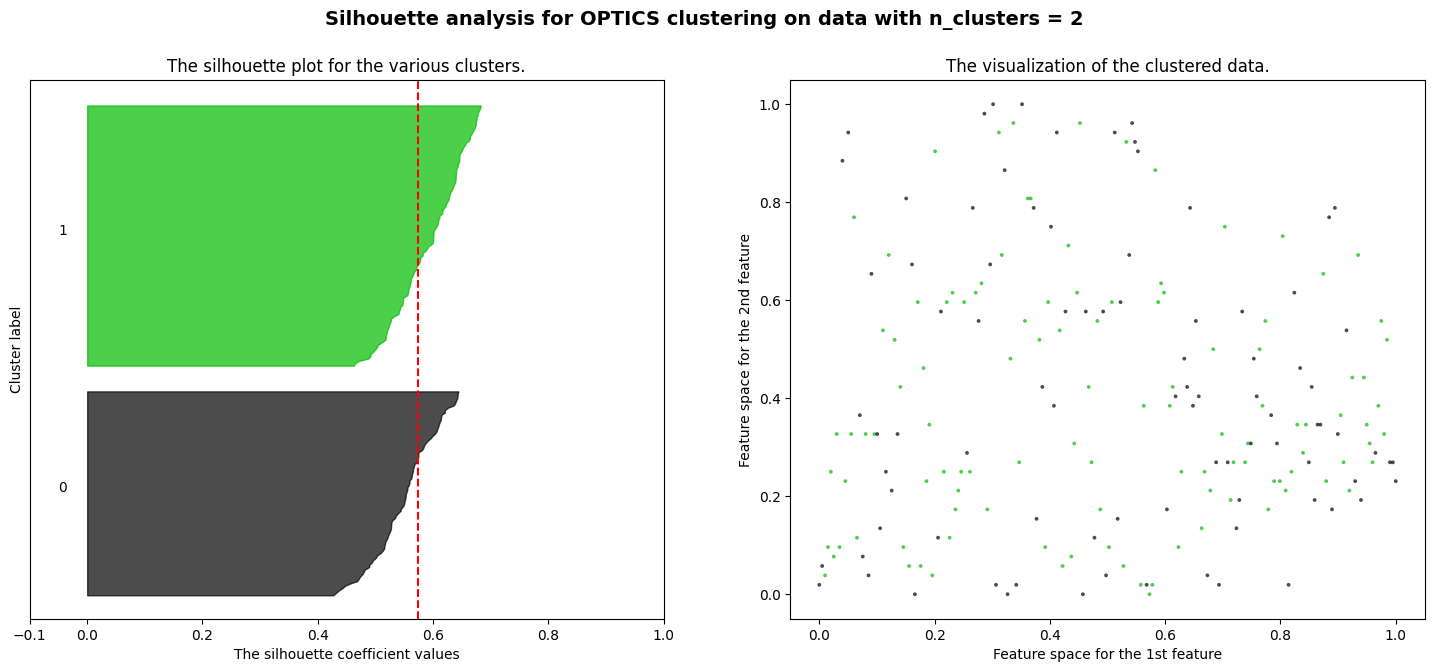

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV 1/1] END ......................n_clusters=3;, score=0.454 total time=   0.0s
[CV 1/1] END ......................n_clusters=4;, score=0.454 total time=   0.0s
[CV 1/1] END ......................n_clusters=5;, score=0.454 total time=   0.0s
[CV 1/1] END ......................n_clusters=6;, score=0.454 total time=   0.0s
[CV 1/1] END ......................n_clusters=7;, score=0.454 total time=   0.0s
[CV 1/1] END ......................n_clusters=8;, score=0.454 total time=   0.0s
[CV 1/1] END ......................n_clusters=9;, score=0.454 total time=   0.0s
For n_clusters = 3 The average silhouette_score is : 0.4537046511975798


c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
c:\Users\Kreshnaa Raam\AppData\Local\Programs\Python\Python310\lib\site-

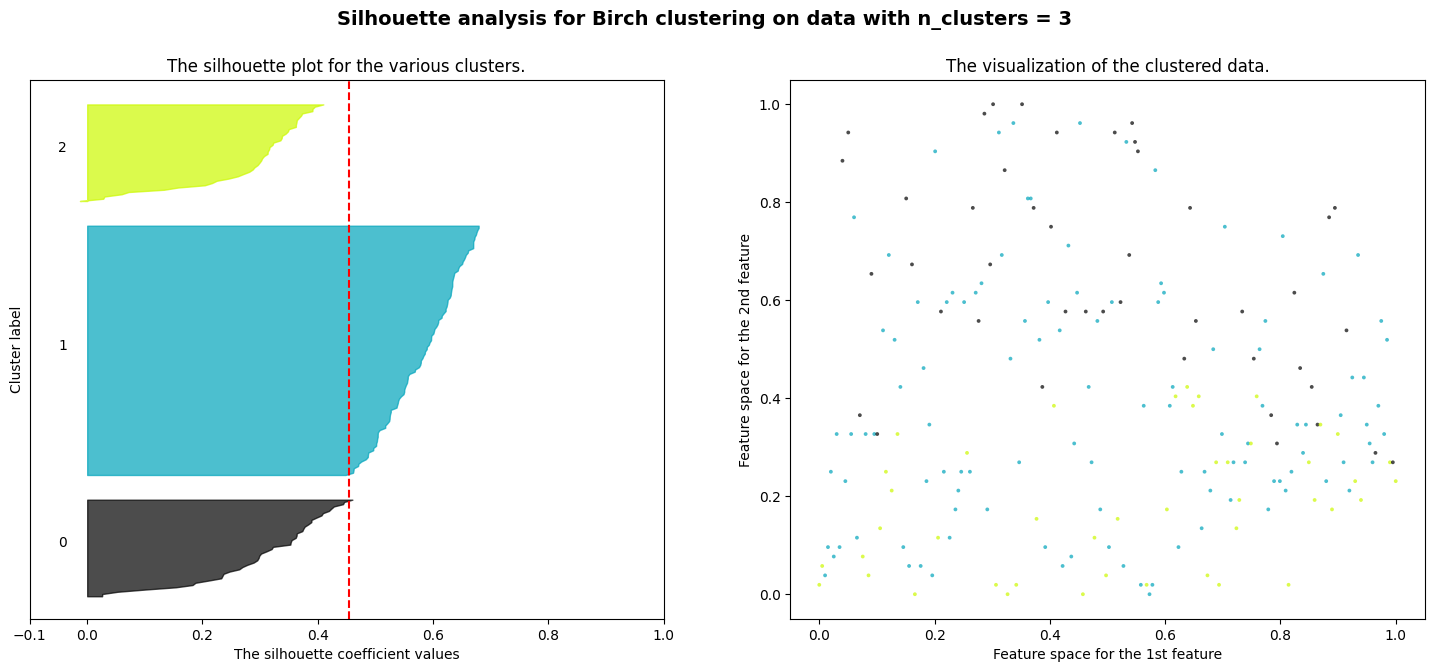

In [5]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# target dataframe: kmeans_data
features = list(kmeans_data.columns)
feature_df = kmeans_data[features]

prediction_df = kmeans_data

# get numerical and categorical columns
bool_cols = feature_df.select_dtypes(include=['bool']).columns.tolist()
kmeans_data[bool_cols] = feature_df[bool_cols].astype(int)
numerical_cols = feature_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object']).columns.tolist()
text_cols = feature_df.select_dtypes(include=['string']).columns.tolist()

sample_size = np.min([10000, kmeans_data.shape[0]])
unique_theshold = np.min([100, sample_size/10])

# check categorical columns for high cardinality and make it text column
for col in categorical_cols:
    if kmeans_data[col].sample(sample_size).nunique() > unique_theshold:
        text_cols.append(col)
        categorical_cols.remove(col)
        

# check text columns for low cardinality and make it categorical columns
for col in text_cols:
    if kmeans_data[col].sample(sample_size).nunique() < unique_theshold:
        categorical_cols.append(col)
        text_cols.remove(col)

print(numerical_cols)
print(categorical_cols)
print(text_cols)

# define numeric transformer steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", MinMaxScaler())]
)

# define categorical transformer steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# define text transformer steps
text_transformer = Pipeline(
    steps=[
        ('text', TfidfVectorizer())
    ]
)

# create the preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer , numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        *[(f'text_{t_col}', text_transformer, t_col) for t_col in text_cols]]
)

# train test split
X_train = kmeans_data[features]

X_train_preprocessed = preprocessor.fit_transform(X_train)


model_comparison_list = []

##### End of Data Processing Pipeline #####


##### Model Pipeline for KMeans #####

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

KMeans_param_grid = {
"n_clusters": np.arange(3, 10, 1),
"max_iter": np.arange(100, 200, 50),
}


KMeans_model = KMeans()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
KMeans_grid_search = GridSearchCV(estimator=KMeans_model, param_grid=KMeans_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
KMeans_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
KMeans_best_estimator = KMeans_grid_search.best_estimator_

# Store results as a dataframe  
KMeans_search_results = pd.DataFrame(KMeans_grid_search.cv_results_)

model_comparison_list.append(KMeans_search_results.loc[KMeans_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(KMeans_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, KMeans_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  KMeans_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[KMeans_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(KMeans_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for KMeans #####
##### Model Pipeline for AffinityPropagation #####

from sklearn.cluster import AffinityPropagation 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

AffinityPropagation_param_grid = {
"convergence_iter": np.arange(15, 50, 20),
"max_iter": np.arange(100, 200, 50),
}


AffinityPropagation_model = AffinityPropagation()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
AffinityPropagation_grid_search = GridSearchCV(estimator=AffinityPropagation_model, param_grid=AffinityPropagation_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
AffinityPropagation_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
AffinityPropagation_best_estimator = AffinityPropagation_grid_search.best_estimator_

# Store results as a dataframe  
AffinityPropagation_search_results = pd.DataFrame(AffinityPropagation_grid_search.cv_results_)

model_comparison_list.append(AffinityPropagation_search_results.loc[AffinityPropagation_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(AffinityPropagation_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, AffinityPropagation_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  AffinityPropagation_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[AffinityPropagation_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(AffinityPropagation_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for AffinityPropagation clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for AffinityPropagation #####
##### Model Pipeline for MeanShift #####

from sklearn.cluster import MeanShift 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

MeanShift_param_grid = {
"max_iter": np.arange(100, 400, 50),
}


MeanShift_model = MeanShift()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
MeanShift_grid_search = GridSearchCV(estimator=MeanShift_model, param_grid=MeanShift_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
MeanShift_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
MeanShift_best_estimator = MeanShift_grid_search.best_estimator_

# Store results as a dataframe  
MeanShift_search_results = pd.DataFrame(MeanShift_grid_search.cv_results_)

model_comparison_list.append(MeanShift_search_results.loc[MeanShift_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(MeanShift_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, MeanShift_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  MeanShift_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[MeanShift_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(MeanShift_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for MeanShift clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for MeanShift #####
##### Model Pipeline for SpectralClustering #####

from sklearn.cluster import SpectralClustering 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

SpectralClustering_param_grid = {
"n_clusters": np.arange(3, 10, 1),
}


SpectralClustering_model = SpectralClustering()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
SpectralClustering_grid_search = GridSearchCV(estimator=SpectralClustering_model, param_grid=SpectralClustering_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
SpectralClustering_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
SpectralClustering_best_estimator = SpectralClustering_grid_search.best_estimator_

# Store results as a dataframe  
SpectralClustering_search_results = pd.DataFrame(SpectralClustering_grid_search.cv_results_)

model_comparison_list.append(SpectralClustering_search_results.loc[SpectralClustering_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(SpectralClustering_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, SpectralClustering_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  SpectralClustering_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[SpectralClustering_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(SpectralClustering_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for SpectralClustering clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for SpectralClustering #####
##### Model Pipeline for AgglomerativeClustering #####

from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

AgglomerativeClustering_param_grid = {
"n_clusters": np.arange(3, 10, 1),
}


AgglomerativeClustering_model = AgglomerativeClustering()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
AgglomerativeClustering_grid_search = GridSearchCV(estimator=AgglomerativeClustering_model, param_grid=AgglomerativeClustering_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
AgglomerativeClustering_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
AgglomerativeClustering_best_estimator = AgglomerativeClustering_grid_search.best_estimator_

# Store results as a dataframe  
AgglomerativeClustering_search_results = pd.DataFrame(AgglomerativeClustering_grid_search.cv_results_)

model_comparison_list.append(AgglomerativeClustering_search_results.loc[AgglomerativeClustering_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(AgglomerativeClustering_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, AgglomerativeClustering_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  AgglomerativeClustering_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[AgglomerativeClustering_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(AgglomerativeClustering_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for AgglomerativeClustering clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for AgglomerativeClustering #####
##### Model Pipeline for DBSCANClustering #####

from sklearn.cluster import DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

DBSCAN_param_grid = {
"eps": np.arange(0.1, 0.5, 0.05),
"min_samples": np.arange(5, 20, 5),
}


DBSCAN_model = DBSCAN()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
DBSCAN_grid_search = GridSearchCV(estimator=DBSCAN_model, param_grid=DBSCAN_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
DBSCAN_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
DBSCAN_best_estimator = DBSCAN_grid_search.best_estimator_

# Store results as a dataframe  
DBSCAN_search_results = pd.DataFrame(DBSCAN_grid_search.cv_results_)

model_comparison_list.append(DBSCAN_search_results.loc[DBSCAN_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(DBSCAN_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, DBSCAN_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  DBSCAN_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[DBSCAN_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(DBSCAN_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for DBSCAN clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for DBSCANClustering #####
##### Model Pipeline for HDBSCANClustering #####

from sklearn.cluster import HDBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

HDBSCAN_param_grid = {
"min_cluster_size": np.arange(5, 20, 5),
}


HDBSCAN_model = HDBSCAN()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
HDBSCAN_grid_search = GridSearchCV(estimator=HDBSCAN_model, param_grid=HDBSCAN_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
HDBSCAN_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
HDBSCAN_best_estimator = HDBSCAN_grid_search.best_estimator_

# Store results as a dataframe  
HDBSCAN_search_results = pd.DataFrame(HDBSCAN_grid_search.cv_results_)

model_comparison_list.append(HDBSCAN_search_results.loc[HDBSCAN_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(HDBSCAN_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, HDBSCAN_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  HDBSCAN_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[HDBSCAN_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(HDBSCAN_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for HDBSCAN clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for HDBSCANClustering #####
##### Model Pipeline for OPTICSClustering #####

from sklearn.cluster import OPTICS 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

OPTICS_param_grid = {
"min_samples": np.arange(0.1, 0.9, 0.1),
}


OPTICS_model = OPTICS()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
OPTICS_grid_search = GridSearchCV(estimator=OPTICS_model, param_grid=OPTICS_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
OPTICS_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
OPTICS_best_estimator = OPTICS_grid_search.best_estimator_

# Store results as a dataframe  
OPTICS_search_results = pd.DataFrame(OPTICS_grid_search.cv_results_)

model_comparison_list.append(OPTICS_search_results.loc[OPTICS_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(OPTICS_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, OPTICS_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  OPTICS_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[OPTICS_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(OPTICS_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for OPTICS clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for OPTICSClustering #####
##### Model Pipeline for BirchClustering #####

from sklearn.cluster import Birch 
from sklearn.metrics import silhouette_samples, silhouette_score 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

Birch_param_grid = {
"n_clusters": np.arange(3, 10, 1),
}


Birch_model = Birch()

def cv_silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)
cv = [(slice(None), slice(None))]

# Create the grid search
Birch_grid_search = GridSearchCV(estimator=Birch_model, param_grid=Birch_param_grid, cv=cv, scoring=cv_silhouette_scorer, verbose=3)
Birch_grid_search.fit(X_train_preprocessed)

# Get the best hyperparameters
Birch_best_estimator = Birch_grid_search.best_estimator_

# Store results as a dataframe  
Birch_search_results = pd.DataFrame(Birch_grid_search.cv_results_)

model_comparison_list.append(Birch_search_results.loc[Birch_search_results['mean_test_score'].idxmax()])

def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

range_n_clusters = as_list(len(np.unique(Birch_best_estimator.labels_)))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_preprocessed) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_preprocessed, Birch_best_estimator.labels_)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_preprocessed,  Birch_best_estimator.labels_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[Birch_best_estimator.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(Birch_best_estimator.labels_.astype(float) / n_clusters)
    ax2.scatter(
        X_train_preprocessed[:, 0], X_train_preprocessed[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for Birch clustering on data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
##### End of Model Pipeline for BirchClustering #####
##### Model Comparison #####

